## Accelerate Inference: Neural Network Pruning

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.9.2


In [ ]:
# untar
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [ ]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [ ]:
model.load_weights("model_orig_weights.h5")

In [ ]:
orig_weights = model.get_weights()
model.set_weights(orig_weights)

Each filter for the convolution layers is (3x3), the input has three channels, and the first layer has 32 filters.

Weights at [0,2,4,6] layers are to be pruned.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
results = model.evaluate(val_images, val_labels, batch_size=128)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 7s 12ms/step - loss: 0.7430 - accuracy: 0.7354


In [ ]:
# model original weights
model.set_weights(orig_weights)

In [ ]:
# prune each layer independently
# prune [60%,30%,5%,5%] subsequently
l = [0,2,4,6] # convolutional layers
p = [0,0,0,0.6]
weights = model.get_weights()
for i in range(len(l)):
  w = weights[l[i]]
  print(w.shape)
  s = np.sum(np.absolute(w),axis=(0,1,2))
  indices = s.argsort()
  #s_sorted = s[indices]
  p_ = p[i]
  prune = indices[:int(len(s)*p_)]
  #print(prune)
  weights[l[i]][:,:,:,prune] = 0
model.set_weights(weights)

(3, 3, 3, 32)
(3, 3, 32, 32)
(3, 3, 32, 64)
(3, 3, 64, 64)


In [ ]:
# evaluate again to see how the accuracy changes
results = model.evaluate(val_images, val_labels, batch_size=128)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 2s 75ms/step - loss: 0.7430 - accuracy: 0.7354


In [ ]:
# train model again after pruning

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=25, 
                    validation_data=(val_images, val_labels))

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


703/703 [==============================] - 4s 5ms/step - loss: 0.6583 - accuracy: 0.7548 - val_loss: 0.7654 - val_accuracy: 0.7133
Epoch 2/25
703/703 [==============================] - 4s 5ms/step - loss: 0.5477 - accuracy: 0.7993 - val_loss: 0.7350 - val_accuracy: 0.7188
Epoch 3/25
703/703 [==============================] - 4s 5ms/step - loss: 0.5221 - accuracy: 0.8038 - val_loss: 0.7225 - val_accuracy: 0.7299
Epoch 4/25
703/703 [==============================] - 4s 5ms/step - loss: 0.4994 - accuracy: 0.8125 - val_loss: 0.7192 - val_accuracy: 0.7390
Epoch 5/25
703/703 [==============================] - 4s 5ms/step - loss: 0.4834 - accuracy: 0.8210 - val_loss: 0.7517 - val_accuracy: 0.7188
Epoch 6/25
703/703 [==============================] - 4s 5ms/step - loss: 0.4775 - accuracy: 0.8190 - val_loss: 0.7365 - val_accuracy: 0.7311
Epoch 7/25
703/703 [==============================] - 4s 5ms/step - loss: 0.4624 - accuracy: 0.8292 - val_loss: 0.7220 - val_accuracy: 0.7335
Epoch 8/25
703/70

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.set_weights(orig_weights)

In [ ]:
# Soft pruning
# Prune at each training epoch
epochs=25
l = [0,2,4,6]
p = [0.6,0.3,0.1,0.1]

for epoch in range(epochs):
  model.fit(train_images, train_labels, batch_size=32, epochs=1, 
                    validation_data=(val_images, val_labels))
  weights = model.get_weights()
  for i in range(len(l)):
    w = weights[l[i]]
    #print(w.shape)
    s = np.sum(np.absolute(w),axis=(0,1,2))
    indices = s.argsort()
    p_ = p[i]
    prune = indices[:int(len(s)*p_)]
    weights[l[i]][:,:,:,prune] = 0
    model.set_weights(weights)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


703/703 [==============================] - 64s 91ms/step - loss: 0.4098 - accuracy: 0.8485 - val_loss: 0.7465 - val_accuracy: 0.7370


In [ ]:
# evaluate again to see how the accuracy changes
results = model.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 2s 112ms/step - loss: 0.7449 - accuracy: 0.7343


In [ ]:
def spar(model):
  weights = model.get_weights()
  t = 0
  nonz = 0
  for w in weights:
    t += w.size
    nonz += np.count_nonzero(w)
  s = (t-nonz)/t
  return s

In [ ]:
sparse = spar(model)
print(sparse)

0.013979657060747167


In [ ]:
# you need to save the model's weights, naming it 'my_model_weights.h5'
model.save_weights("model_weights.h5")

# running this cell will immediately download a file called 'my_model_weights.h5'
from google.colab import files
files.download("model_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import glob
files = sorted(glob.glob("layer*.txt"))

In [ ]:
print(files)

['layer1.txt', 'layer2.txt', 'layer3.txt', 'layer4.txt']


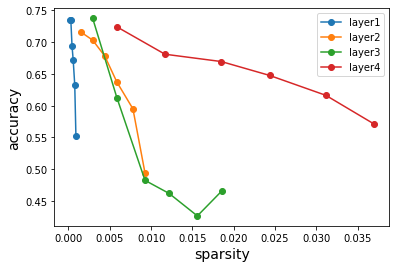

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(files)):
  data = np.loadtxt(files[i])
  sparse = data[:,1]
  acc = data[:,2]
  plt.plot(sparse,acc,label="layer"+f"{i+1}",marker='o')
plt.xlabel("sparsity",size=14)
plt.ylabel("accuracy",size=14)
plt.legend()
plt.show()
plt.savefig("L1norm.png")